In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold,learning_curve
sns.set(style='white',context='notebook',palette='deep')

In [2]:
train = pd.read_csv('F:/ML_Python/DataSets/Titanic_Data/train.csv')
test = pd.read_csv('F:/ML_Python/DataSets/Titanic_Data/test.csv')
IDtest = test['PassengerId']

## Outlier Detection Using Tukey method

In [3]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over dataframe
    for col in features:
        # Find 1st Quartile
        Q1 = np.percentile(df[col],25)
        # Find 3rd Quartile
        Q3 = np.percentile(df[col],75)
        # Find Interquartile Range
        IQR = Q3 - Q1
        
        # setting outlier_step to 1.5
        outlier_step = 1.5 * IQR
        
        # Determine a lot of indices of outliers for feature column
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step) ].index
        
        # appending indices 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list( k for k,v in outlier_indices.items() if v > n)
    
    return multiple_outliers

# detecting outliers in titanic dataset for SibSp, Age, Parch and Fare features
outliers_to_drop = detect_outliers(train,2,['SibSp', 'Age', 'Parch', 'Fare'])

C:\Users\HP\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [4]:
train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
train = train.drop(outliers_to_drop,axis=0).reset_index(drop=True)

In [6]:
train_len = len(train)
df = pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [7]:
# Fill empty values with NaN

df.fillna(np.nan, inplace=True)

# Checking for null values
df.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [9]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Correlation Plot for Nnumerical Variables

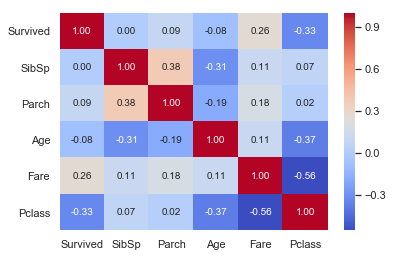

In [15]:
# Correlation between numerical values 
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare','Pclass']].corr(),annot=True,fmt='.2f',cmap='coolwarm')

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


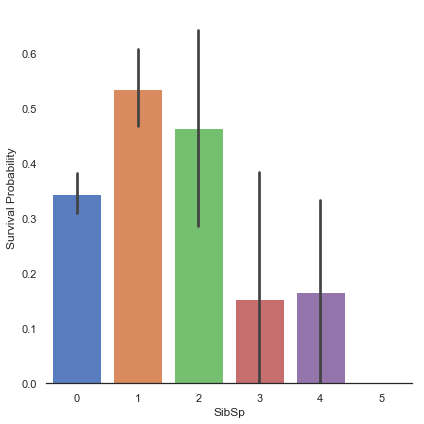

In [17]:
## Explore SibSp feature vs Survived

g = sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


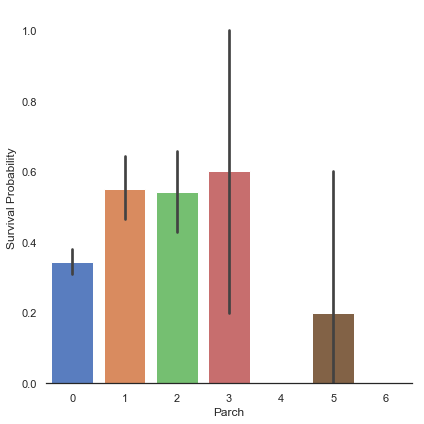

In [18]:
## Explore Parch feature vs Survived

g = sns.factorplot(x='Parch',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

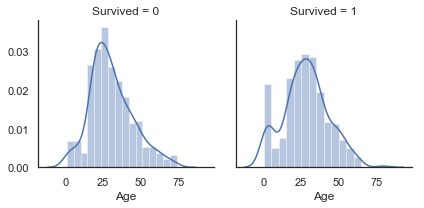

In [19]:
## Explore Age vs Survived

g = sns.FacetGrid(train,col='Survived')
g = g.map(sns.distplot,'Age')

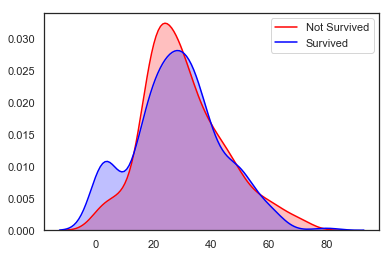

In [20]:
# Explore Age Distributions

g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())],color='Red',shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())],color='Blue',shade=True,ax=g)
g = g.legend(['Not Survived','Survived'])

In [22]:
df['Fare'].isnull().sum()
df['Fare'].fillna(df['Fare'].median(),inplace=True)

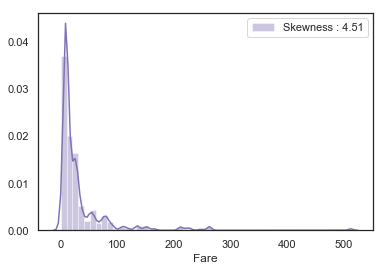

In [23]:
# Exploring Fare distribution

g = sns.distplot(df['Fare'],color='m',label='Skewness : %.2f'%(df['Fare'].skew()))
g = g.legend(loc='best')

In [24]:
df['Fare'] = df['Fare'].map(lambda x : np.log(x) if x > 0 else 0)

In [25]:
!pip install spacy

['Requirement already satisfied: spacy in c:\\users\\hp\\anaconda3\\lib\\site-packages (2.2.3)',
 'Requirement already satisfied: requests<3.0.0,>=2.13.0 in c:\\users\\hp\\anaconda3\\lib\\site-packages (from spacy) (2.21.0)',
 'Requirement already satisfied: blis<0.5.0,>=0.4.0 in c:\\users\\hp\\anaconda3\\lib\\site-packages (from spacy) (0.4.1)',
 'Requirement already satisfied: plac<1.2.0,>=0.9.6 in c:\\users\\hp\\anaconda3\\lib\\site-packages (from spacy) (1.1.3)',
 'Requirement already satisfied: murmurhash<1.1.0,>=0.28.0 in c:\\users\\hp\\anaconda3\\lib\\site-packages (from spacy) (1.0.2)',
 'Requirement already satisfied: wasabi<1.1.0,>=0.4.0 in c:\\users\\hp\\anaconda3\\lib\\site-packages (from spacy) (0.6.0)',
 'Requirement already satisfied: numpy>=1.15.0 in c:\\users\\hp\\anaconda3\\lib\\site-packages (from spacy) (1.16.2)',
 'Requirement already satisfied: setuptools in c:\\users\\hp\\anaconda3\\lib\\site-packages (from spacy) (45.0.0)',
 'Requirement already satisfied: presh

In [26]:
!python -m spacy download en

  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-cp37-none-any.whl size=12011744 sha256=f07c96477098f1153637117c25b1af010553fb11d03f852d6c0e899ed187873f
  Stored in directory: C:\Users\HP\AppData\Local\Temp\pip-ephem-wheel-cache-kbw66r8k\wheels\6a\47\fb\6b5a0b8906d8e8779246c67d4658fd8a544d4a03a75520197a
Successfully built en-core-web-sm
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\HP\Anaconda3\lib\site-packages\en_core_web_sm -->
C:\Users\HP\Anaconda3\lib\site-packages\spacy\data\en
[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can stil

You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You do not have sufficient privilege to perform this operation.


In [27]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [29]:
doc = nlp (u'Tesla is looking to buy U.S startups in $6 Million')
for token in doc:
           print(token.text, token.pos_, token.dep_)

Tesla PROPN nsubj
is AUX aux
looking VERB ROOT
to PART aux
buy VERB xcomp
U.S PROPN compound
startups NOUN dobj
in ADP prep
$ SYM quantmod
6 NUM compound
Million NUM pobj


In [30]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x19422070860>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x1942220dfa8>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x1942221d048>)]

In [32]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [34]:
doc2 = nlp(u"Tesla isn't looking into startups anymore.")
for token in doc2:
    print(token.text, token.pos_, token.dep_)

Tesla PROPN nsubj
is AUX aux
n't PART neg
looking VERB ROOT
into ADP prep
startups NOUN pobj
anymore ADV advmod
. PUNCT punct


In [41]:
### Tokenize 
mystring = "We are moving to L.A. !"
print(mystring)

We are moving to L.A. !


In [43]:
doc = nlp(mystring)
for token in doc:
    print(token.text, end = ' | ')

We | are | moving | to | L.A. | ! | 

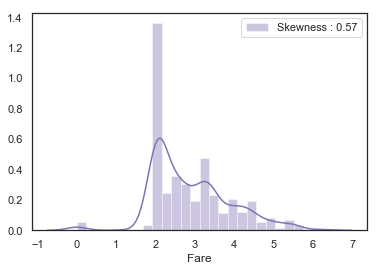

In [44]:

g = sns.distplot(df['Fare'],color='m',label='Skewness : %.2f'%(df['Fare'].skew()))
g = g.legend(loc='best')

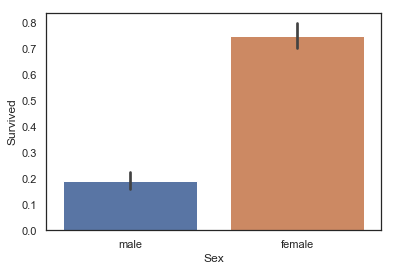

In [45]:
g = sns.barplot(x='Sex',y='Survived',data=train)

In [46]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


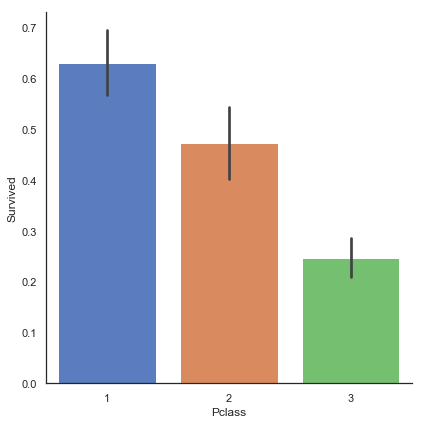

In [47]:
# Explore Pclass vs Survived

g = sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',size=6,palette='muted')

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


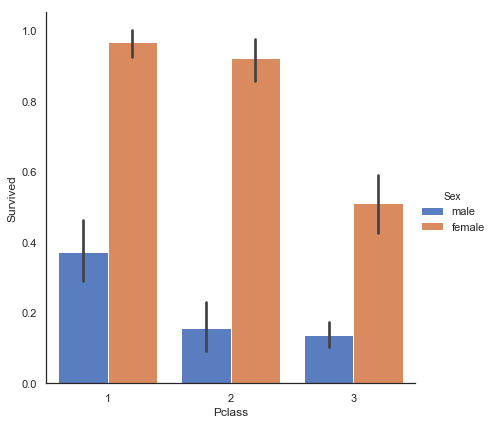

In [48]:
# Explore Pclass vs Survived by Sex

g = sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',size=6,palette='muted',hue='Sex')

In [49]:
df['Embarked'].isnull().sum()

2

In [50]:
df['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [51]:
df['Embarked'].fillna('S',inplace=True)

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


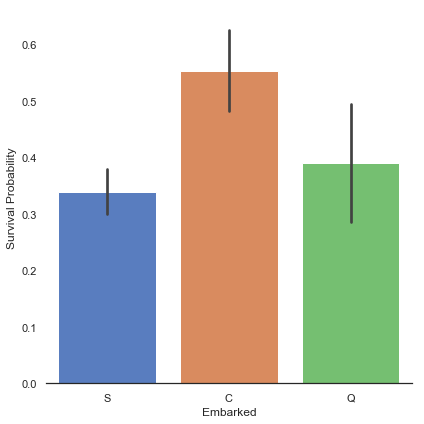

In [52]:
# Explore Embarked vs Survived

g = sns.factorplot(x='Embarked',y='Survived',data=train,size=6,kind='bar',palette='muted')
g.despine(left=True)
g=g.set_ylabels("Survival Probability")

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


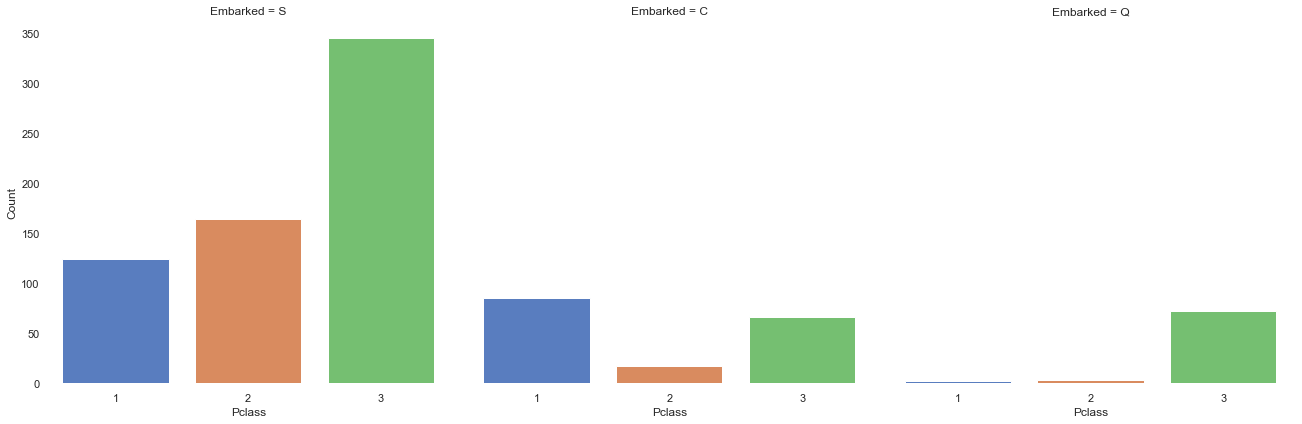

In [53]:
# Exploring Pclass vs Embarked

g = sns.factorplot('Pclass',col='Embarked',data=train,size=6,kind='count',palette='muted')
g.despine(left=True,bottom=True)
g=g.set_ylabels("Count")

In [54]:
df.isnull().sum()

Age             256
Cabin          1007
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

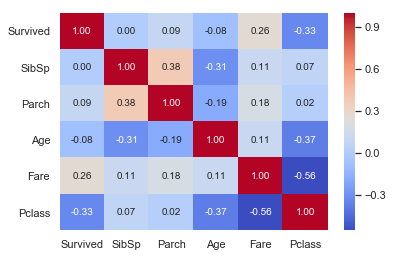

In [55]:
# Correlation between numerical values 
g = sns.heatmap(train[['Sex','Survived','SibSp','Parch','Age','Fare','Pclass']].corr(),annot=True,fmt='.2f',cmap='coolwarm')


C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C

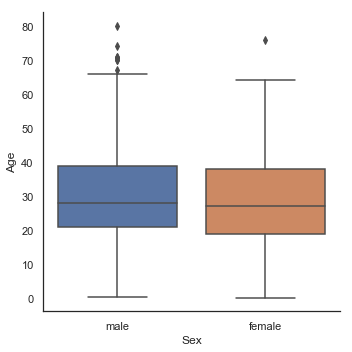

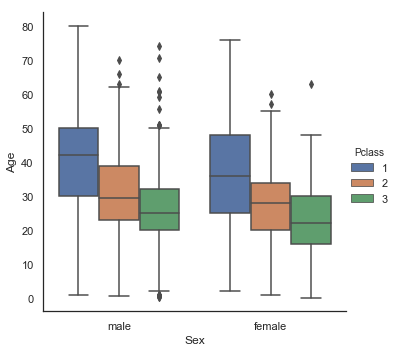

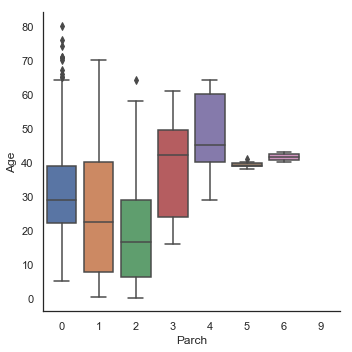

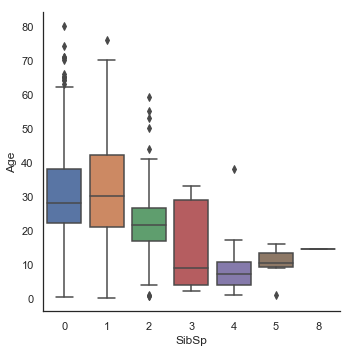

In [56]:
g = sns.factorplot(y='Age',x='Sex',data=df,kind='box')

g = sns.factorplot(y='Age',x='Sex',hue='Pclass',data=df,kind='box')

g = sns.factorplot(y='Age',x='Parch',data=df,kind='box')

g = sns.factorplot(y='Age',x='SibSp',data=df,kind='box')

In [57]:
# convert sex into a categorical value

df['Sex'] = df['Sex'].map({'male':0,'female':1})

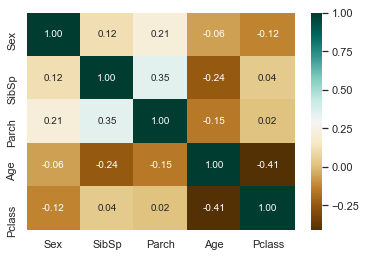

In [58]:
g = sns.heatmap(df[['Sex','SibSp','Parch','Age','Pclass']].corr(),annot=True,fmt='.2f',cmap='BrBG')

In [59]:
# Filling missing values of age

# Fill Age with median age of similar rows accoring to Pclass, Parch and SibSp

index_NaN_age = list(df['Age'][df['Age'].isnull()].index)

for i in index_NaN_age:
    age_median = df['Age'].median()
    age_pred = df['Age'][((df['SibSp'] == df.iloc[i]['SibSp']) & (df['Parch'] == df.iloc[i]['Parch']) & 
                          (df['Pclass'] == df.iloc[i]['Pclass']))].median()
    
    if not np.isnan(age_pred):
        df['Age'].iloc[i] = age_pred
    else:
        df['Age'].iloc[i] = age_median

C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [60]:
df['Age'][((df['SibSp'] == df.iloc[i]['SibSp']) & (df['Parch'] == df.iloc[i]['Parch']) & 
                          (df['Pclass'] == df.iloc[i]['Pclass']))].median()

16.0

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


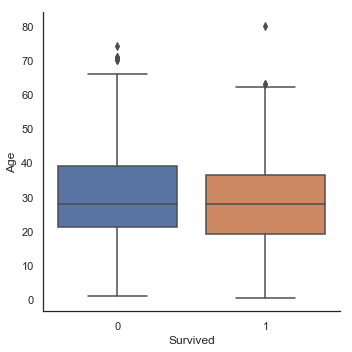

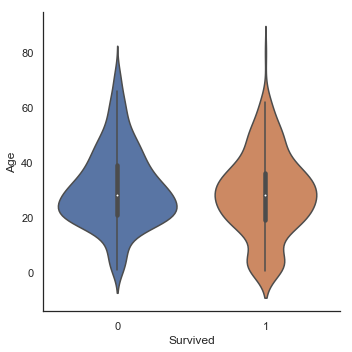

In [61]:
g = sns.factorplot(x='Survived',y='Age',data=train,kind='box')
g = sns.factorplot(x='Survived',y='Age',data=train,kind='violin')

In [62]:
df['Name'].head(30)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [63]:
# Getting titles from name

#df['Name'][0].split(',')[1].split('.')[0].strip()


df_title = [i.split(',')[1].split('.')[0].strip() for i in df['Name']]
df['Title']=pd.Series(df_title)
df['Title'].head()


0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

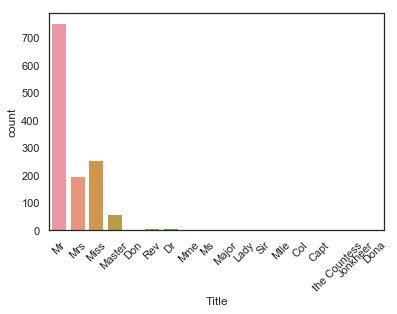

In [64]:
g = sns.countplot(x='Title',data=df)
g = plt.setp(g.get_xticklabels(),rotation=45)

In [65]:
df['Title'].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Capt              1
Jonkheer          1
Lady              1
Mme               1
Sir               1
Don               1
Dona              1
the Countess      1
Name: Title, dtype: int64

In [66]:
df['Title'].value_counts()


Mr              753
Miss            255
Mrs             197
Master           60
Dr                8
Rev               8
Col               4
Ms                2
Mlle              2
Major             2
Capt              1
Jonkheer          1
Lady              1
Mme               1
Sir               1
Don               1
Dona              1
the Countess      1
Name: Title, dtype: int64

In [67]:
df['Title'] = df['Title'].replace(['Lady','Jonkheer','the Countess','Major',
                                  'Ms','Mlle','Col','Rev','Dr','Sir','Mme','Dona'
                                 ,'Don','Capt'],'Rare')

# Convert Title into a categorical variable

df['Title'] = df['Title'].map({'Mr':0,'Miss':1,'Mrs':1,'Master':2,'Rare':3})

df['Title'] = df['Title'].astype(int)

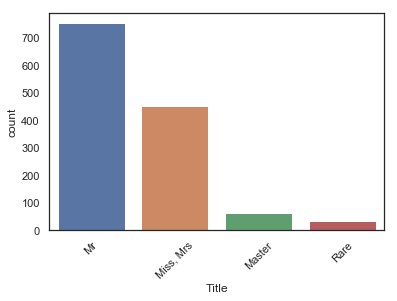

In [68]:
g = sns.countplot(x='Title',data=df)
g = plt.setp(g.set_xticklabels(['Mr','Miss, Mrs','Master','Rare']),rotation=45)

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


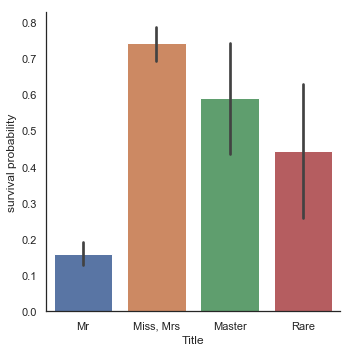

In [69]:
g = sns.factorplot(x='Title',y='Survived',data=df,kind='bar')
g = g.set_xticklabels(['Mr','Miss, Mrs','Master','Rare'])
g = g.set_ylabels('survival probability')

In [70]:
df.drop(['Name'],axis=1,inplace=True)

In [72]:
df['Fsize'] = df['SibSp'] + df['Parch'] + 1

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


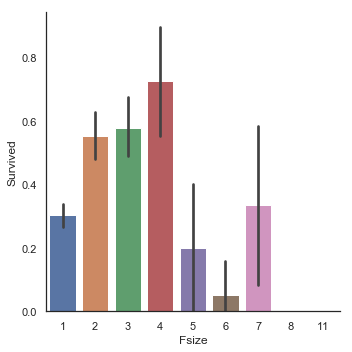

In [73]:
g = sns.factorplot(x='Fsize',y='Survived',data=df,kind='bar')



In [74]:
df['Single'] = df['Fsize'].map(lambda s:1 if s==1 else 0)
df['SmallF'] = df['Fsize'].map(lambda s:1 if s==2 else 0)
df['MediumF'] = df['Fsize'].map(lambda s:1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['Fsize'].map(lambda s:1 if s > 4 else 0)

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C

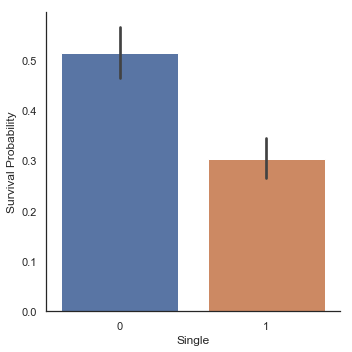

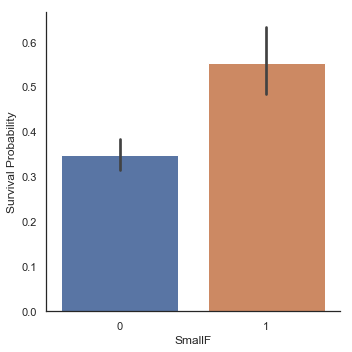

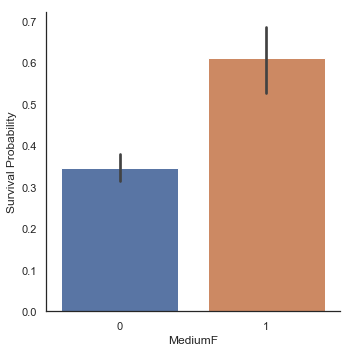

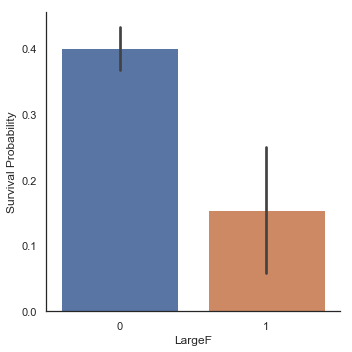

In [75]:
g = sns.factorplot(x='Single',y='Survived',data=df,kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x='SmallF',y='Survived',data=df,kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x='MediumF',y='Survived',data=df,kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x='LargeF',y='Survived',data=df,kind='bar')
g = g.set_ylabels('Survival Probability')



In [76]:
# convert to indicator values Title and Embarked

df = pd.get_dummies(df,columns=['Title'])
df = pd.get_dummies(df,columns=['Embarked'],prefix='Em')

In [77]:
df['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [78]:
df['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [79]:
df['Cabin'].isnull().sum()

1007

In [80]:
df['Cabin'][df['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [81]:
# Replace the cabin number by type of cabin 
# and if nothing is there means cabin is missing then we'll replace it with 'X'


df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin']])

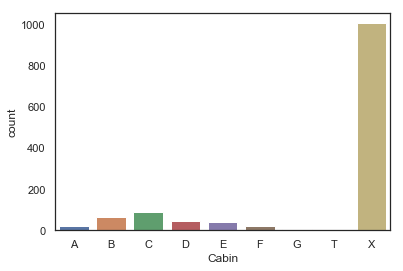

In [82]:
g = sns.countplot(df['Cabin'],order=['A','B','C','D','E','F','G','T','X'])

C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


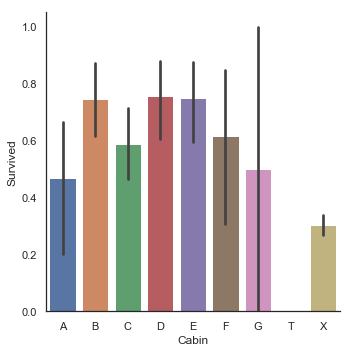

In [83]:
g = sns.factorplot(x='Cabin',y='Survived',kind='bar',data=df,order=['A','B','C','D','E','F','G','T','X'])

In [84]:
df = pd.get_dummies(df,columns=['Cabin'],prefix='Cabin')

In [85]:
df['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [86]:
# Treat ticket by extracting the prefix, when there is no prefix replace with X


Ticket = []

for i in list(df.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
    else:
        Ticket.append('X')
        
df['Ticket'] = Ticket

In [87]:
df.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,1.981001,0,1,3,0,1,0.0,A5,2,...,1,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,2,1,1,1,1.0,PC,2,...,0,0,0,1,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,STONO2,1,...,1,0,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,4,1,1,1,1.0,X,2,...,1,0,0,1,0,0,0,0,0,0
4,35.0,2.085672,0,5,3,0,0,0.0,X,1,...,1,0,0,0,0,0,0,0,0,1


In [88]:
df = pd.get_dummies(df,columns=['Ticket'],prefix='T')

In [89]:
df.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Fsize,Single,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,22.0,1.981001,0,1,3,0,1,0.0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,4.266662,0,2,1,1,1,1.0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,1,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,3.972177,0,4,1,1,1,1.0,2,0,...,0,0,0,0,0,0,0,0,0,1
4,35.0,2.085672,0,5,3,0,0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [90]:
# Create categorical values for Pclass

df['Pclass'] = df['Pclass'].astype('category')
df = pd.get_dummies(df,columns=['Pclass'],prefix='pc')

In [91]:
df.drop(labels=['PassengerId'],axis=1,inplace=True)

In [92]:
df.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MediumF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,pc_1,pc_2,pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [93]:
# Separate out train and test datasets

train = df[:train_len]
test = df[train_len:]

In [94]:
test.drop(['Survived'],axis=1,inplace=True)

C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [95]:
# Split training data into features and target variables

train['Survived'] = train['Survived'].astype(int)

y_train = train['Survived']

X_train = train.drop('Survived',axis=1)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
# Cross validate model with K-fold stratified cross val

kfold = StratifiedKFold(n_splits=10)

In [97]:
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))

classifiers.append(DecisionTreeClassifier(random_state=random_state))

classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate=0.1))

classifiers.append(RandomForestClassifier(random_state=random_state))

classifiers.append(ExtraTreesClassifier(random_state=random_state))

classifiers.append(GradientBoostingClassifier(random_state=random_state))

classifiers.append(MLPClassifier(random_state=random_state))

classifiers.append(KNeighborsClassifier())

classifiers.append(LogisticRegression(random_state=random_state))

classifiers.append(LinearDiscriminantAnalysis())

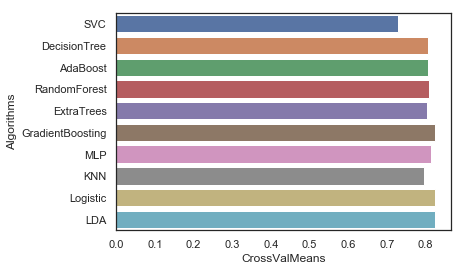

In [98]:
cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,X_train,y=y_train,scoring='accuracy',cv=kfold,n_jobs=4))
    
cv_means = []
cv_std = []

#print(len(cv_means))
#print(len(cv_std))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_results = pd.DataFrame({'CrossValMeans':cv_means,'CrossValErrors':cv_std,
                           'Algorithms':['SVC','DecisionTree','AdaBoost','RandomForest','ExtraTrees',
                                         'GradientBoosting','MLP','KNN','Logistic','LDA']})

g = sns.barplot('CrossValMeans','Algorithms',data=cv_results)

In [99]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC,random_state=7)

ada_param_grid = {'base_estimator__splitter':['best','random'],
                 'n_estimators':[1,2],
                 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid=ada_param_grid,cv=kfold,scoring='accuracy',n_jobs=1,verbose=1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    4.5s finished


In [100]:
gsadaDTC.best_score_

0.8082482124616955